##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [2]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [3]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [4]:
###...code...###

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [22]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:

    import csv
    import pandas as pd
    import numpy as np

    filepath = './data/catA_train.csv'
    data = pd.read_csv(filepath)

    # Drop columns that are not necessary
    columns_to_drop = ["LATITUDE", "LONGITUDE", '8-Digit SIC Code', 'Sales (Global Ultimate Total USD)', "AccountID", "Company", "Industry", "8-Digit SIC Description", "Parent Company", "Company Description", "Square Footage", "Company Status (Active/Inactive)", "Import/Export Status", "Fiscal Year End", "Global Ultimate Company", "Domestic Ultimate Company"]
    data = data.drop(columns=columns_to_drop)

    # Drop null values for 3 variables

    data = data.dropna(subset=["Year Found", "Parent Country", "Global Ultimate Country"])
    data.isna().sum()
    
    # Categorizing "SIC Code" for One-hot encoding

    data['SIC Code'] = pd.to_numeric(data['SIC Code'])

    def categorize_industry(sic_code):
        if 100 <= sic_code <= 999:
            return 'Agriculture, Forestry, And Fishing'
        elif 1000 <= sic_code <= 1499:
            return 'Mining'
        elif 1500 <= sic_code <= 1799:
            return 'Construction'
        elif 2000 <= sic_code <= 3999:
            return 'Manufacturing'
        elif 4000 <= sic_code <= 4999:
            return 'Transportation, Communications, Electric, Gas, And Sanitary Services'
        elif 5000 <= sic_code <= 5199:
            return 'Wholesale Trade'
        elif 5200 <= sic_code <= 5999:
            return 'Retail Trade'
        elif 6000 <= sic_code <= 6799:
            return 'Finance, Insurance, And Real Estate'
        elif 7000 <= sic_code <= 8999:
            return 'Services'
        elif 9000 <= sic_code <= 9999:
            return 'Public Administration'
        else:
            return 'Other'  # Handle cases not covered by the specified ranges

    # Apply the categorization function to create a new 'Industry' column
    data['Industry'] = data['SIC Code'].apply(categorize_industry)

    data.drop('SIC Code', axis=1, inplace=True)
    data

    # One-Hot Encoding for "Industry"

    industry_frequency = data["Industry"].value_counts()

    industry_dummies = pd.get_dummies(data["Industry"])
    merged_data1 = pd.concat([data, industry_dummies], axis='columns')
    data = merged_data1.drop(['Industry'], axis='columns')
    data

    # One-Hot Encoding for "Entity Type"

    entity_frequency = data["Entity Type"].value_counts()
    # 4 categories: "Branch", "Independent", "Parent", "Subsidiary"
    entity_dummies = pd.get_dummies(data["Entity Type"])
    merged_data1 = pd.concat([data, entity_dummies], axis='columns')
    data = merged_data1.drop(['Entity Type'], axis='columns')
    data

    # One-Hot Encoding for "Ownership Type"

    ownership_frequency = data["Ownership Type"].value_counts()
    ownership_frequency # 6 categories: "Private", "Public", "Partnership", "Public Sector", "Non-Corporates", "Nonprofit"
    ownership_dummies = pd.get_dummies(data["Ownership Type"])
    merged_data2 = pd.concat([data, ownership_dummies], axis='columns')
    data = merged_data2.drop(['Ownership Type'], axis='columns')

    data

    # Label Encoding for Parent Country
    from sklearn.preprocessing import LabelEncoder

    parent_frequency = data['Parent Country'].value_counts()
    parent_frequency # 69 countries

    # Set a threshold for low-frequency countries
    threshold = 3

    # Identify Countries with frequency below the threshold
    low_frequency_parent_country = parent_frequency[parent_frequency < threshold].index

    # Replace these low-frequency countries with a common label "Others"
    data['Parent Country'] = data['Parent Country'].replace(low_frequency_parent_country, 'Others')

    parent_frequency1 = data['Parent Country'].value_counts()

    data['Parent Country'] = data['Parent Country'].astype(str)
    label_encoder = LabelEncoder()
    data['Parent Country'] = label_encoder.fit_transform(data['Parent Country'])
    data

    # Label Encoding for Global Ultimate Country
    global_frequency = data['Global Ultimate Country'].value_counts()
    global_frequency # 74 countries
    #sorted_global = global_frequency.abs().sort_values(ascending=True)
    #print(sorted_global[:25])

    # Set a threshold for low-frequency countries
    threshold = 5

    # Identify Countries with frequency below the threshold
    low_frequency_global_country = global_frequency[global_frequency < threshold].index

    # Replace these low-frequency countries with a common label "Others"
    data['Global Ultimate Country'] = data['Global Ultimate Country'].replace(low_frequency_global_country, 'Others')

    global_frequency1 = data['Global Ultimate Country'].value_counts()

    data['Global Ultimate Country'] = data['Global Ultimate Country'].astype(str)
    label_encoder = LabelEncoder()
    data['Global Ultimate Country'] = label_encoder.fit_transform(data['Global Ultimate Country'])

    data

    # Rename the columns created by target encoding

    data.rename (columns = {'Sales (Domestic Ultimate Total USD)_y': 'Parent Country'}, inplace=True)
    data.rename (columns = {'Sales (Domestic Ultimate Total USD)_x_y': 'Global Ultimate Country'}, inplace=True)
    data.rename (columns = {'Sales (Domestic Ultimate Total USD)_x_x': 'Sales (Domestic Ultimate Total USD)'}, inplace=True)

    data

    # Predicting missing values using Bayesian Linear Regression (Regression Imputation)

    import numpy as np
    import pandas as pd
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.linear_model import BayesianRidge

    missing_col = ['Employees (Single Site)', 'Employees (Domestic Ultimate Total)', 'Employees (Global Ultimate Total)']
    predic_col = ['Year Found', 'Sales (Domestic Ultimate Total USD)', 'Is Domestic Ultimate', 'Is Global Ultimate', 'Branch', 'Independent','Parent', 'Subsidiary', 'Non-Corporates', 'Nonprofit', 'Partnership', 'Private', 'Public', 'Public Sector', 'Agriculture, Forestry, And Fishing',
        'Construction', 'Finance, Insurance, And Real Estate', 'Manufacturing',
        'Mining', 'Public Administration', 'Retail Trade', 'Services',
        'Transportation, Communications, Electric, Gas, And Sanitary Services',
        'Wholesale Trade', 'Parent Country',
        'Global Ultimate Country']

    imputer = IterativeImputer(estimator=BayesianRidge())
    imputed_data = imputer.fit_transform(data[predic_col + missing_col])
    data[missing_col] = imputed_data[:, -len(missing_col):]

    data.isna().sum()

    # Data Visualization using correlation heatmap

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(30, 30))

    corr_matrix = data.corr()
    heatmap = sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".1f")
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    plt.title("Correlation Heatmap")
    plt.show()

    # 0.9 -- "Is Global Ultimate" = "Parent", "Subsidary"

    # Feature Scaling - Normalizarion

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    data

    # Feature Selection

    correlation_matrix = data.corr()

    target_feature = 'Sales (Domestic Ultimate Total USD)'

    correlation_with_target = correlation_matrix[target_feature]
    sorted_correlations = correlation_with_target.abs().sort_values(ascending=False)
    sorted_correlations = sorted_correlations.drop(target_feature)

    print("Features in Descending Order of Correlation:\n", sorted_correlations)
    print("Top 10 Features:\n", sorted_correlations[:10])

    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold, cross_val_score
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    X = data[['Global Ultimate Country', 'Is Domestic Ultimate', 'Transportation, Communications, Electric, Gas, And Sanitary Services', 'Is Global Ultimate', 'Services', 'Finance, Insurance, And Real Estate', 'Employees (Domestic Ultimate Total)', 'Year Found', 'Retail Trade', 'Manufacturing']]
    y = data[['Sales (Domestic Ultimate Total USD)']]

    # Only features that have the correlation above 0.01
    # drop "Is Global Ultimate" = "Parent", "Subsidary"

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest Regressor
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Feature importance
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importance')
    plt.show()

    # Cross Validation - Random Forest Regressor
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
    import numpy as np
    import statsmodels.api as sm

    # Feature columns
    X = data[['Global Ultimate Country', 'Parent Country', 'Is Domestic Ultimate', 'Transportation, Communications, Electric, Gas, And Sanitary Services', 'Is Global Ultimate', 'Services', 'Finance, Insurance, And Real Estate', 'Employees (Domestic Ultimate Total)', 'Year Found', 'Retail Trade', 'Manufacturing']]

    # Target column
    y = data['Sales (Domestic Ultimate Total USD)']

    # Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Cross-validation with k-fold (k=10)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Custom scoring functions
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Store metrics for each fold
    r2_scores = []
    adj_r2_scores = []
    aic_bic_scores = []
    mse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit RandomForestRegressor
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        # Calculate R² and adjusted R²
        r2 = r2_score(y_test, y_pred)
        n = X_test.shape[0]
        p = X_test.shape[1]
        adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

        # Calculate AIC/BIC using statsmodels
        X_train_sm = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train_sm).fit()
        aic_bic = model.aic, model.bic

        # Calculate MSE and MAE
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        # Store metrics for each fold
        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)
        aic_bic_scores.append(aic_bic)
        mse_scores.append(mse)
        mae_scores.append(mae)

        # Display results
        print(f"Average R²: {np.mean(r2_scores)}")
        print(f"Average Adj R²: {np.mean(adj_r2_scores)}")
        print(f"Average AIC/BIC: {np.mean(aic_bic_scores, axis=0)}")
        print(f"Average MSE: {np.mean(mse_scores)}")
        print(f"Average MAE: {np.mean(mae_scores)}")

        # Gradient Boosting Regressor
        from sklearn.model_selection import train_test_split
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.metrics import mean_squared_error, r2_score
        import matplotlib.pyplot as plt

        gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

        gbm_model.fit(X_train, y_train)

        y_pred = gbm_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'Mean Squared Error: {mse}')
        print(f'R-squared: {r2}')

        # Feature importance
        feature_importances = pd.Series(gbm_model.feature_importances_, index=X.columns)
        feature_importances.sort_values(ascending=False, inplace=True)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        feature_importances.plot(kind='bar')
        plt.title('Feature Importance')
        plt.show()

        result = [] 
        return result

##### Cell to check testing_hidden_data function

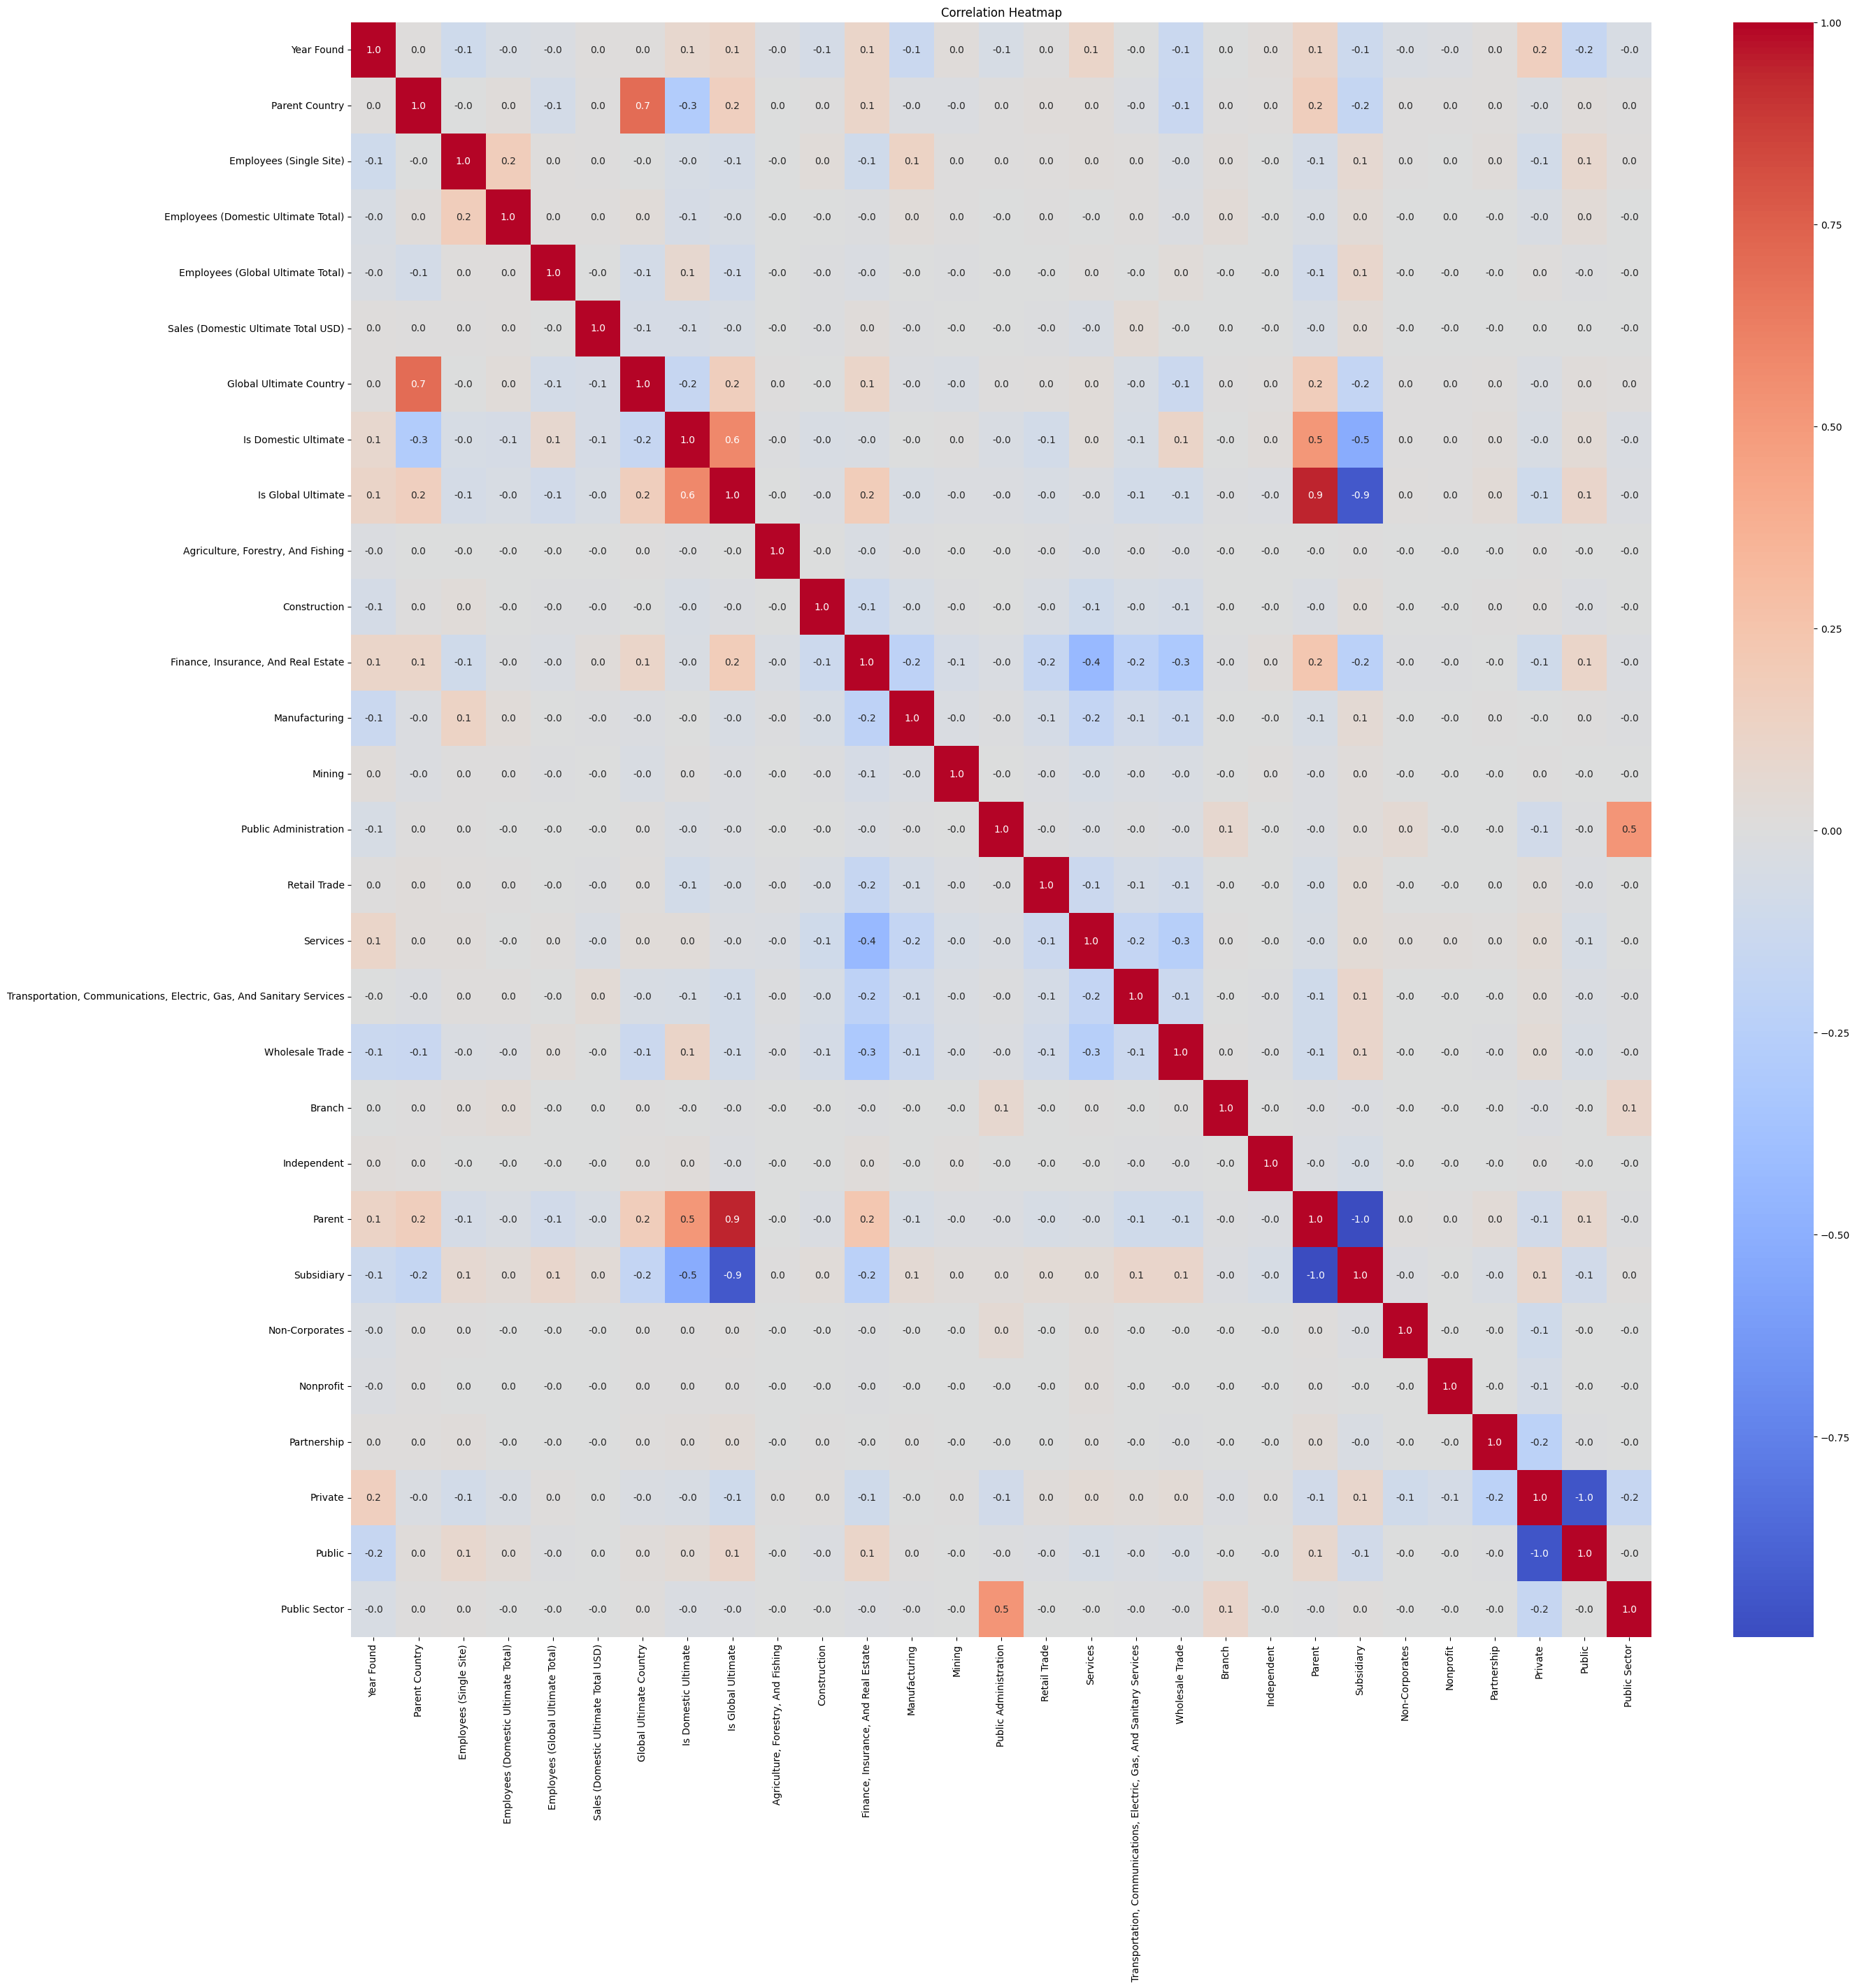

Features in Descending Order of Correlation:
 Global Ultimate Country                                                 0.060760
Is Domestic Ultimate                                                    0.056515
Transportation, Communications, Electric, Gas, And Sanitary Services    0.047409
Is Global Ultimate                                                      0.040201
Subsidiary                                                              0.038416
Parent                                                                  0.038329
Services                                                                0.032597
Finance, Insurance, And Real Estate                                     0.022524
Employees (Domestic Ultimate Total)                                     0.016033
Year Found                                                              0.015215
Retail Trade                                                            0.013135
Manufacturing                                                  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.0002891685067913432
R-squared: 0.8174148650339199


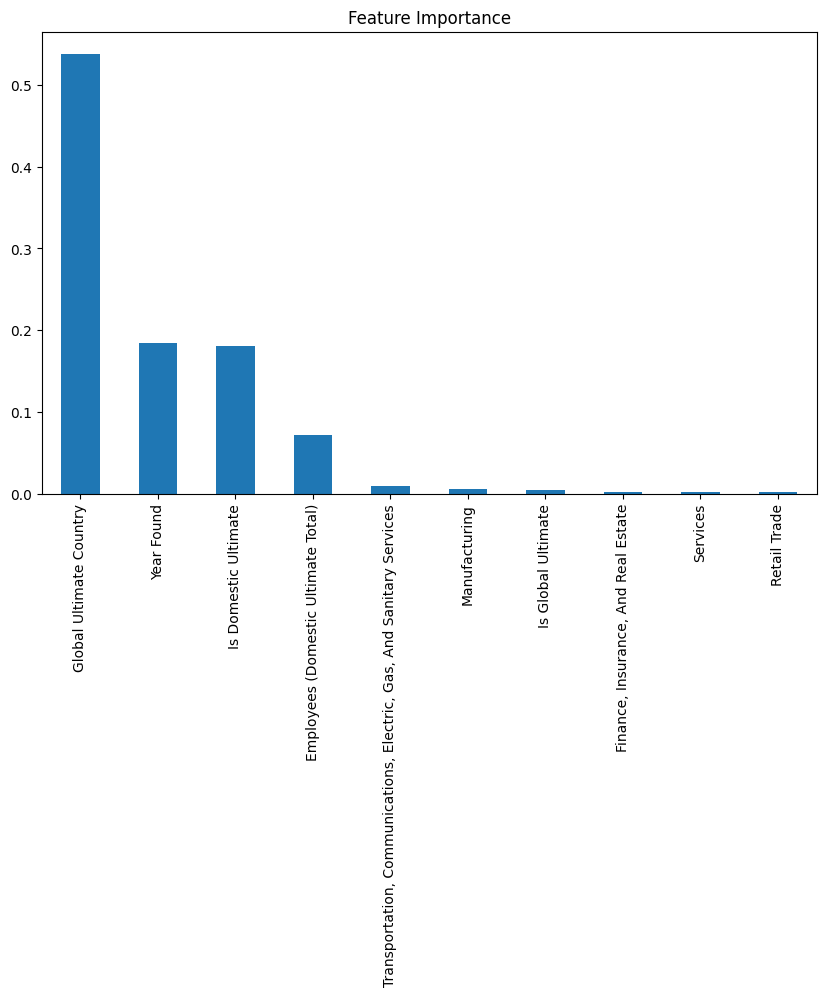

Average R²: 0.6566465348736212
Average Adj R²: 0.6553034025420459
Average AIC/BIC: [-102576.75404643 -102479.03926952]
Average MSE: 0.00039377154801007336
Average MAE: 0.0020348182311057767
Mean Squared Error: 0.00029283326928032915
R-squared: 0.744660785626099


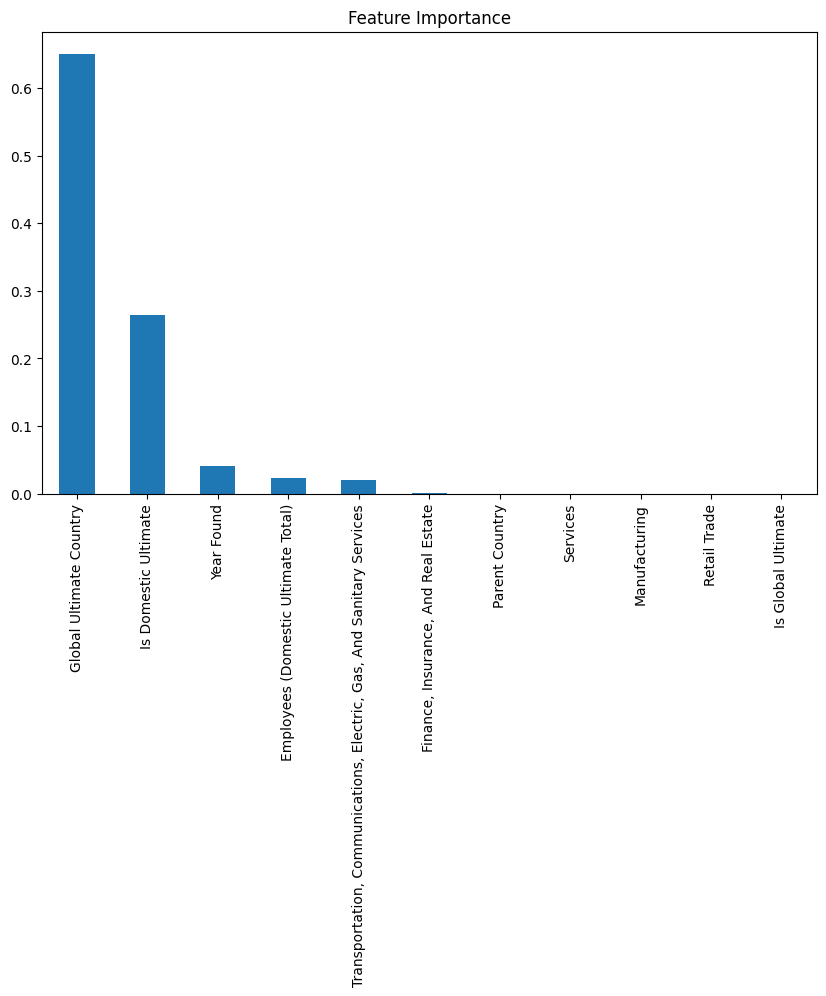

[]


In [23]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!